<a href="https://colab.research.google.com/github/nicas83/ispr22/blob/main/GNicassio_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install hmmlearn

# Assignment 1

Fit an Hidden Markov Model with Gaussian emissions to the data in DSET1: it is sufficient to focus on the “Appliances” and “Lights” columns of the dataset which measure the energy consumption of appliances and lights, respectively, across a period of 4.5 months. Consider the two columns in isolation, i.e. train two separate HMM, one for appliances and one for light.  Experiment with HMMs with a varying number of hidden states (e.g. at least 2, 3 and 4). Once trained the HMMs, perform Viterbi on a reasonably sized subsequence (e.g. 1 month of data) and plot the timeseries data highlighting (e.g. with different colours) the hidden state assigned to each timepoint by the Viterbi algorithm.  Then, fit a single HMM emitting both appliance and light with the same model and repeat the Viterbi assessment. Confront the two results.

In [ ]:
import matplotlib.pyplot as plot
import pandas as pd
import numpy as np
import seaborn as sns
from hmmlearn import hmm
from sklearn.model_selection import train_test_split

In the experiment below, the first step was to import the entire dataset and manipulate it as needed.

In [ ]:
def import_dataset(plot_data=False):
    data = pd.read_csv('/content/energydata_complete.csv')
    # convert string date into dateformat
    data["date"] = pd.to_datetime(data["date"])

    if plot_data:
        # plotting the initial dataset considering only datetime and appliances
        # data = data[data["date"] <= pd.to_datetime("2016-02-02 ")]
        figure, ax = plot.subplots(figsize=(15, 15))
        ax.plot(data["date"], data["Appliances"])
        ax.autoscale(enable=True, axis="x", tight=True)
        plot.show()

        # plotting the initial dataset considering only datetime and lights
        figure, ax = plot.subplots(figsize=(15, 15))
        ax.plot(data["date"], data["lights"])
        ax.autoscale(enable=True, axis="x", tight=True)
        plot.show()

    return data

# Single Feature Experiment

Considering the Hidden Markov Model for the given dataset, respectively for the "*Appliances*" feature and for the "*lights*" feature with respectively 2,3 and 4 hidden states.
For each experiment is important to split the dataset into training set and validation set (80-20) to ensure that the model is fitting well. After the model selection phase, I will extract the best model founded using the score() function given by the library.

Then make the assumption on the n_component variable that means make assumption on the states of the HMM (high, low, medium for example).
For the experiment, let's assume the following sequence of hidden variables, referring to the energy consumption of the appliance:
- 2 hidden state: low, high
- 3 hidden state: low, medium, high
- 4 hidden state: low, medium, high, very high

We also assume that the initial set of parameters, i.e. the transition matrix and the emission matrix, are unknown. The model, through the EM algorithm, will calculate them directly from the observed distribution.


## Functions Definition
The function below trains all the combinations for the HMM and give in ouput the best model scored. As first step we'll do the train_test split use the appropriate library. For the model selection I assumed to split the dataset with the ratio 80-20 (80% for the training set, 20% for the test set)

In [ ]:
def hmm_model_selection(data: pd.DataFrame, variable_selected, shuffle=False):
    x_train, x_test = train_test_split(data, test_size=0.2, shuffle=shuffle)

    # model selection on HMM with different hidden states
    x_fit = x_train[[variable_selected]].values
    x_score = x_test[[variable_selected]].values
    scores = list()
    models = list()
    for n_components in (2,3,4):
        #for idx in range(random_state):
        # define the hidden Markov model
        model_trained = hmm.GaussianHMM(n_components=n_components,
                                        covariance_type='full', n_iter=1000,
                                        random_state=42)
        model_trained.fit(x_fit)
        models.append(model_trained)
        # scoring each model with the TS
        scores.append(model_trained.score(x_score))

    # get the best model
    best_model = models[np.argmax(scores)]
    n_states = best_model.n_components
    print(f'The best model had a score of {max(scores)} and {n_states} '
          'states')
    return best_model

After the model selection phase, with the best model selected, I applied the Viterbi algorithm to a restricted time space (1 month, April 2016 in the case of the experiment).
The model selection output a model with 4 hidden states and the parameters transaction matrix and the start probability as shown in the output of the function "*plot_parameters()*".
The function "*plot_result()*" plot the timeseries data highlighting the hidden state assigned to each timepoint by the Viterbi algorithm

In [ ]:
def applying_prediction(data: pd.DataFrame, model, variable_selected, start_date: None, end_date: None):
    # Appling the Viterbi algorithm to a restricted period of 1 month
    # restrict period to a month (bad choise to restrict the period, find another way better)
    data = data[data["date"] >= pd.to_datetime(start_date)]
    data = data[data["date"] <= pd.to_datetime(end_date)]
    hidden_states = model.predict(data[[variable_selected]].values)

    return hidden_states, data


In [ ]:
def plot_parameters(model, hidden_states):
   #plot the start_probability, emission_probability, and transition_probability matrices.
    
    print("\nPredicted Distinct States")
    print(pd.unique(hidden_states))
    
    print("\nStart probabilities:")
    print(model.startprob_)

    print("\nTransaction Matrix:")
    plot.figure(figsize=(5,5))
    sns.heatmap(model.transmat_,annot=True) #cmap="Greens"
    plot.show()
 

In [ ]:
def plot_results(data: pd.DataFrame, hidden_states, x_variable, y_variable, label):
    # plot the data with states
  
    fig, ax3 = plot.subplots(figsize=(18, 7))
    #plotting initial data
    #ax3.plot(data[x_variable], data[y_variable])

    #plotting the states on the data
    for i in states:
      want = (hidden_states == i)
      x = data[x_variable].iloc[want]
      y = data[y_variable].iloc[want]
      ax3.plot(x, y, '.')

   
    ax3.autoscale(enable=True, axis="x", tight=True)
    ax3.legend(states, fontsize=10)
    ax3.grid(visible=True)
    fig.show()

## Appliances Feature Experiment
To see the results, execute the code below, first for the "Appliances" feature and after that, for the "lights" feature.

In [ ]:
dataset = import_dataset(False)
# model selection steps for the two variables analyzed
model = hmm_model_selection(dataset, 'Appliances', shuffle=True)


Predicted Distinct States
[0 3 2 1]

Start probabilities:
[1.00000000e+000 5.72596040e-241 2.84106382e-071 1.44445726e-251]

Transaction Matrix:


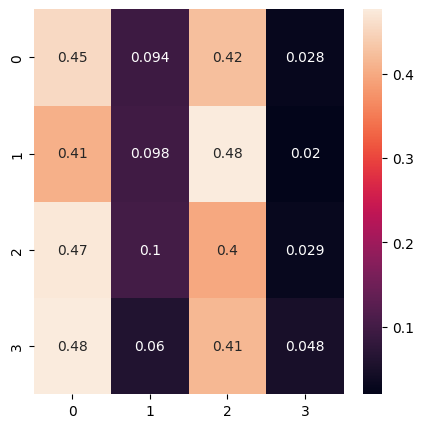

In [ ]:
plot_parameters(model)
# compute Viterbi algorithm in a restricted period of date
prediction, dataset = applying_prediction(dataset, model, 'Appliances', '2016-04-01', '2016-04-30')

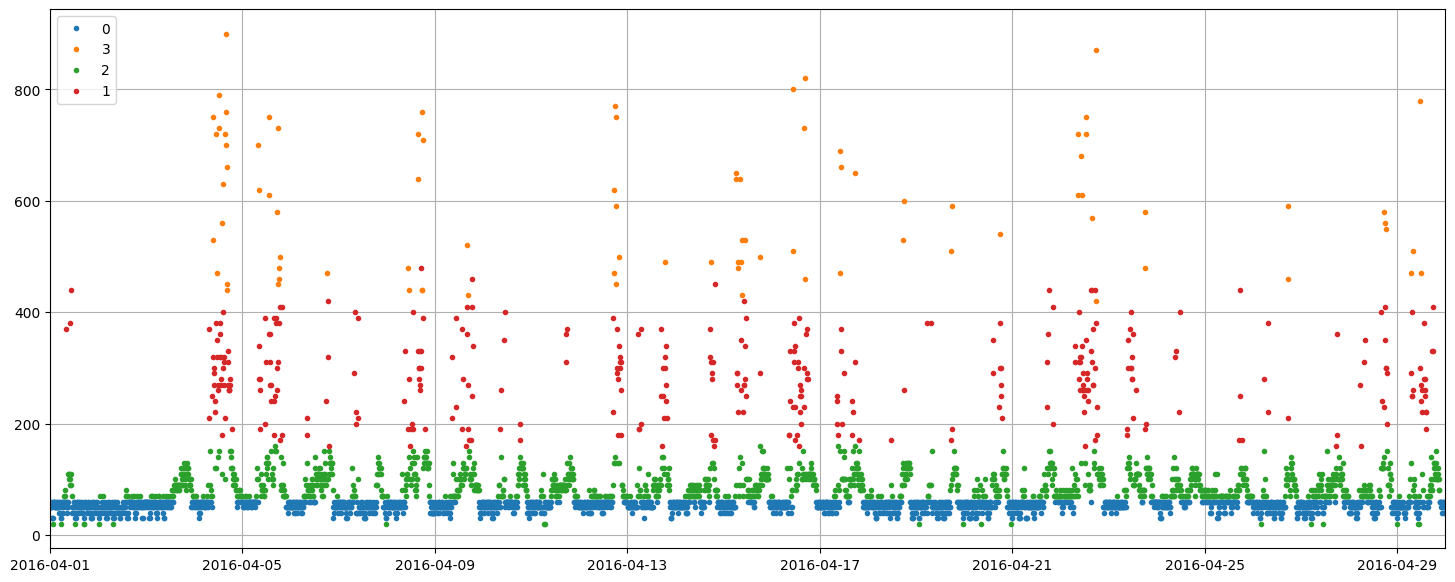

In [ ]:
plot_results(dataset, prediction, 'date', 'Appliances', 'consumption')

## Lights Feature Experiment
Here is the code for the Markov model for the "*lights*" features only

In [ ]:
dataset = import_dataset(False)
# model selection steps for the two variables analyzed
model = hmm_model_selection(dataset, 'lights', True)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The best model had a score of 14029.178506930466 and 4 states



Predicted Distinct States
[0 3 2 1]

Start probabilities:
[0.00000000e+00 3.88373898e-17 1.00000000e+00 0.00000000e+00]

Transaction Matrix:


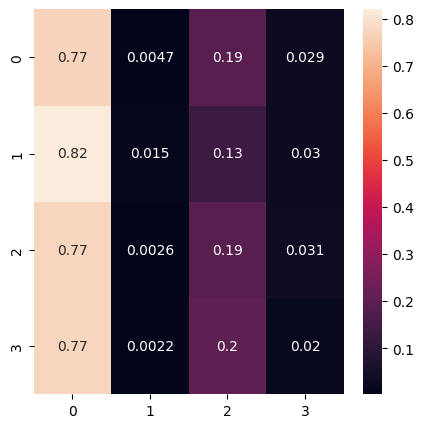

In [ ]:
plot_parameters(model)
prediction, dataset = applying_prediction(dataset, model, 'lights', '2016-04-01', '2016-04-30')

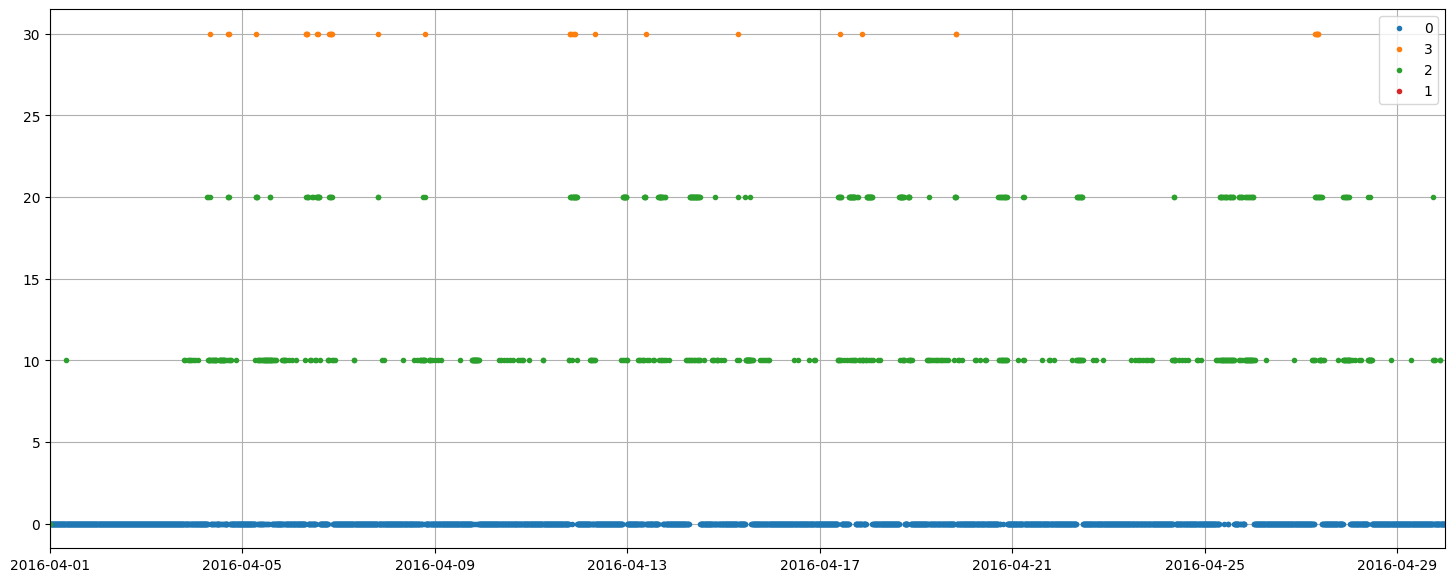

In [ ]:
plot_results(dataset, prediction, 'date', 'lights', 'consumption')

##Conclusions
The application of the model, in the case of the features "*Appliances*" and "*lights*" generated 4 states in both cases, which we assume are "low consumption", "medium consumption", "high consumption" and "very high consumption".
In the case of the "Appliances" feature experiment, from a look at the data we map the states as follows:

*   0 = low consumption (blue)
*   1 = high consumption (red)
*   2 = medium consumption (green)
* 3 = very high consumption (orange)

In the case of the "lights" feature, the mapping is as follows:
*   0 = low consumption (blue)
*   1 = very high consumption (red)
*   2 = medium consumption (green)
* 3 = high consumption (orange)

From the graphs above, it can be seen that high consumption corresponds to the times in which, presumably, the house in question is inhabited. In the "Appliances" graph, anomalous behavior can be seen in which, at consumption values close to 0, a medium consumption status is assigned. By re-executing the model and restricting it to the period 01-04/04-04, I noted that the transition from low to medium state (green and orange dots in the picture below) occurs in an inverse manner. It could be caused by errors in the dataset, but should be tested more, changing and tuning parameters in the model for example.
(only the final result of the re-execution of the experiment is entered in the notebook)
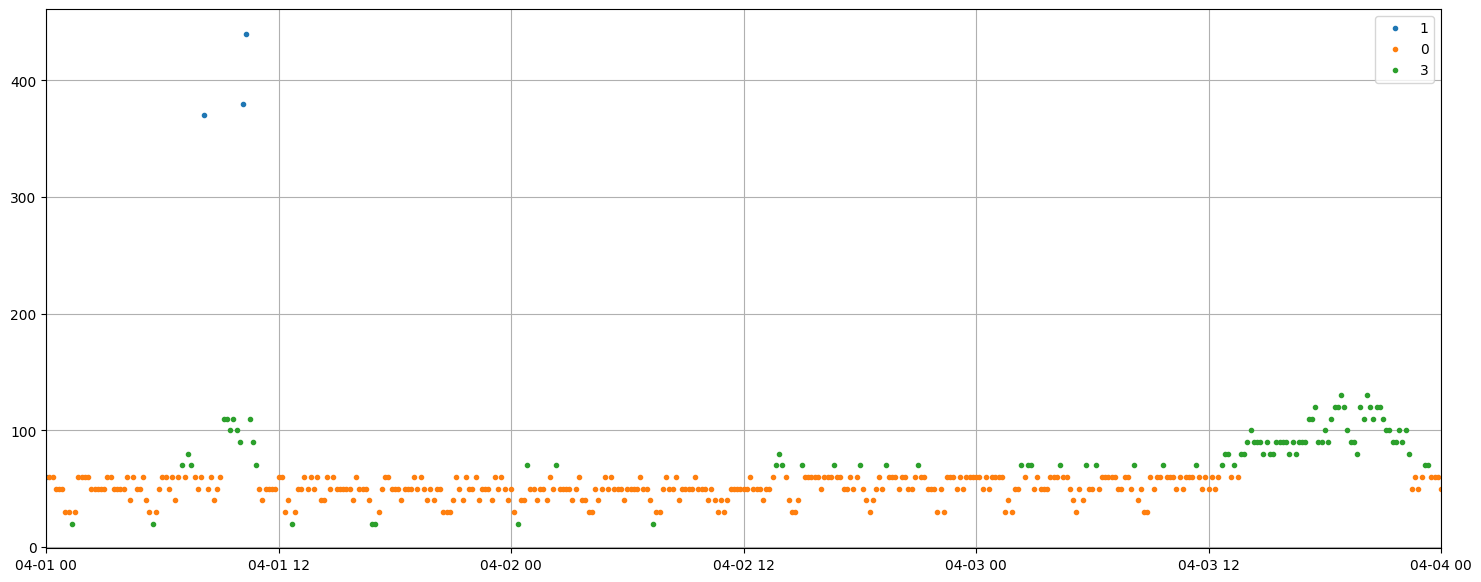


In the graph of the "*light*" feature, although the model predicted 4 states, the data does not express the very high state (red)

# Multiple Features Experiment

Using the same dataset, I did the experiment of the HMM with a bidimensional dataset, combining both "Appliances" and "lights" observations, in order to verify if the model given can be more accurate then the single feature ones.

##Functions definition

In [ ]:
def import_dataset():
  data = pd.read_csv('/content/energydata_complete.csv')
  # convert string date into dateformat
  data['date'] = pd.to_datetime(data['date'])
  #dataset = data[['date', 'Appliances', 'lights']]

  # check if there is a correlation between the two variables
  x = data[['Appliances','lights']]
  x1 = np.array(data['Appliances'])
  x2 = np.array (data['lights'])

  return np.concatenate([x1,x2]), data

In [ ]:
def hmm_model_selection(data: pd.DataFrame, shuffle=False):
  x_train, x_test = train_test_split(data, test_size=0.2, shuffle=True)

  # model selection on HMM with different hidden states
  scores = list()
  models = list()

  for n_components in (2, 3, 4):
      # define the hidden Markov model
      model_trained = hmm.GaussianHMM(n_components=n_components,
                                      covariance_type='full', n_iter=1000, random_state=42)
      model_trained.fit(np.reshape(x_train,[len(x_train),1])) #[[variable_selected[0], variable_selected[1]]].values
      models.append(model_trained)
      # scoring each model with the TS
      scores.append(model_trained.score(np.reshape(x_test,[len(x_test),1])))

  # get the best model
  best_model = models[np.argmax(scores)]
  n_states = best_model.n_components
  print(f'The best model had a score of {max(scores)} and {n_states} '
        'states')
  
  return best_model

In [ ]:
def applying_prediction(data: pd.DataFrame, model, variable_selected, start_date: None, end_date: None):

  data = data[data["date"] >= pd.to_datetime('2016-04-01')]
  data = data[data["date"] <= pd.to_datetime('2016-04-30')]
  y1 = np.array(data['Appliances'])
  y2 = np.array (data['lights'])
  data_analyzed = np.concatenate([y1,y2])
  hidden_states = model.predict(np.reshape(data_analyzed,[len(data_analyzed),1]))
  x1 = np.array(data['date'])
  x2 = np.array(data['date'])
  timestamp = np.concatenate([x1, x2])

  return hidden_states, data_analyzed, timestamp

def plot_parameters(model, hidden_states):
    print("\nPredicted Distinct States")
    print(pd.unique(hidden_states))
    
    print("\nStart probabilities:")
    print(model.startprob_)

    print("\nTransaction Matrix:")
    plot.figure(figsize=(5,5))
    sns.heatmap(model.transmat_, cmap="Reds", annot=True) 
    plot.show()


In [ ]:
def plot_results(y_data: pd.DataFrame, x_data:pd.DataFrame, hidden_states, x_variable, y_variable, label):
  fig, ax = plot.subplots(figsize=(18, 7))

  states = pd.unique(hidden_states)
  for i in states:
      masks = hidden_states == i
      ax.scatter(x_data[masks], y_data[masks])
      #ax.plot(x_data, y_data, c='k')

  ax.autoscale(enable=True, axis="x", tight=True)
  ax.legend(states, fontsize=10)
  ax.grid(visible=True)
  plot.title(y_variable + ' Hidden States')
  fig.show()

##Experiment Execution
In order too see the final output, execute the code below.

In [ ]:
exp_data, dataset = import_dataset()


In [ ]:
# model selection steps for the two variables analyzed
model = hmm_model_selection(exp_data, shuffle=True)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The best model had a score of -12069.527590950485 and 4 states



Predicted Distinct States
[2 0 1 3]

Start probabilities:
[0. 0. 1. 0.]

Transaction Matrix:


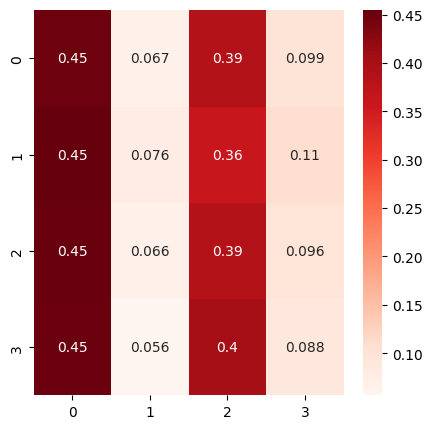

In [ ]:
# compute Viterbi algorithm in a restricted period of date
prediction, dataset, timestamp = applying_prediction(dataset, model, ['Appliances','lights'], '2016-04-01', '2016-04-30')
plot_parameters(model, prediction)

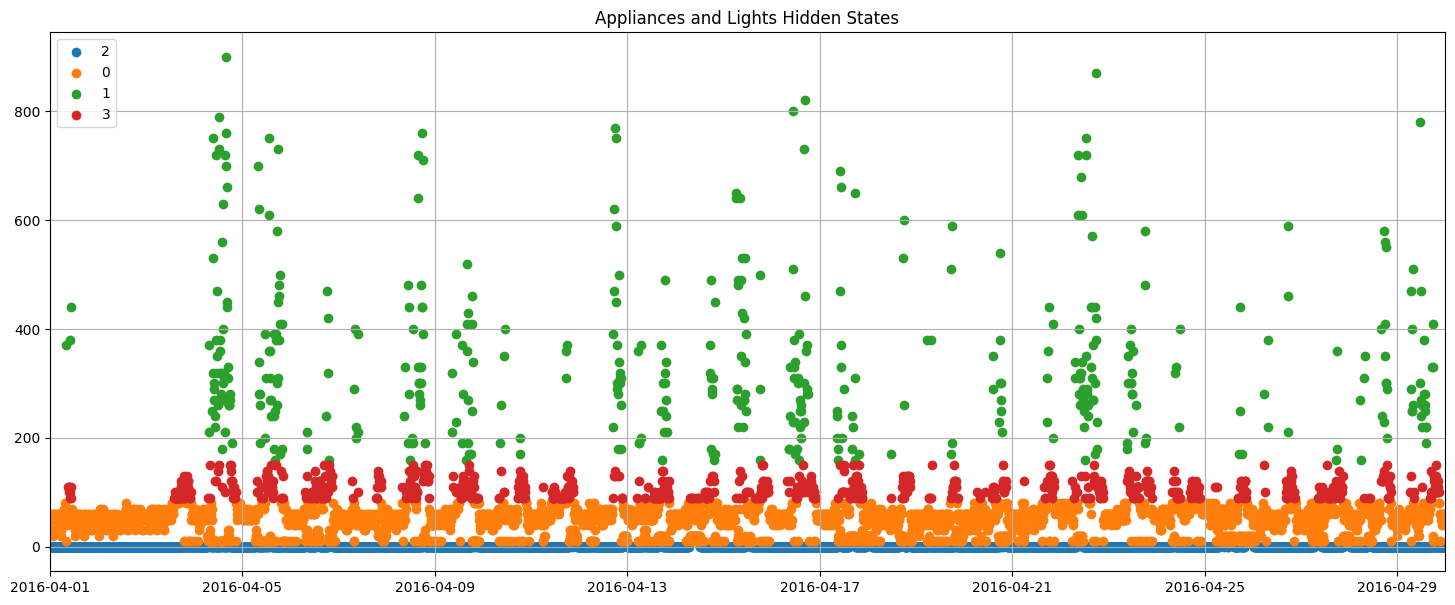

In [ ]:
#feature appliances
plot_results(dataset, timestamp, prediction, 'date', 'Appliances and Lights', 'consumption')

## Conclusions
The model selection process gave in output a model with 4 hidden states (as in the case of single feature experiments). However, by plotting the results, the hidden states are represented in a more "compact" way than in the previous cases, redefining the previously identified classes. What you get is that values classified as "high consumption" in the case of a single sequence of observations are moved to the "very high consumption" cluster also because the light consumption measurements are much lower than those of appliances.

# Final Conclusions

Hidden Markov Models interprets the (nonobservable) process by analyzing the pattern of a sequence of observed symbols. An HMM consists of a doubly stochastic process, in which the underlying (or hidden) stochastic process can be indirectly inferred by analyzing the sequence of observed symbols of another set of stochastic processes. In the experiments above, in addition to observing a more stringent classification of the states, as in the case of the experiment with multiple data sequences, the transition probability between the low and medium states remains almost identical, which turns out to be higher both in the case of a single observation and of multiple observations.